In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../extract_centerline/")
sys.path.append("../extract_centerline/bin/")
sys.path.append("util/")
!ls

Classical_methods.py	      Segnet_pytorch.py
classical_segmentation.ipynb  SegNet_segmentation.ipynb
dataset.py		      testing_platform.ipynb
load_data.py		      Unet_pytorch.py
logs			      UNet_segmentation.ipynb
__pycache__		      util
saved_models


In [13]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import numpy as np
from tqdm.notebook import tqdm
import wireskeletonise 
from PIL import Image
import subprocess 
from centerline_extraction import * 
from util import show_images 

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# (Option 1) Generate data
Run the Matlab engine to call scripts that generate data

In [14]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import pathlib
import os

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 5.371002197265625 seconds


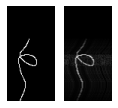

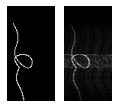

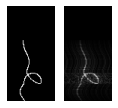

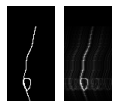

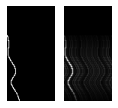

Simulation took 3.1735169887542725 seconds


In [15]:
data = []

blur = 1.3
im_size = eng.cell2mat([128.0, 64.0])
sim_start = time.time()
for i in range(5):
#     pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, 0.75, nargout = 2)
    ground_truth, simulated = eng.simulate(pts, im_size, 1.3, 1.0, 1.3, 10.0, 0.2, 0, 0, nargout=2)
    show_images([ground_truth, simulated])
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

# (Option 2) Load data
Load data saved in a <tt>.mat</tt> file

In [16]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y, pts = load_data('.', '../data/toy_dataset', spline_pts = True)

In [17]:
import dataset
from sklearn.model_selection import train_test_split

batch_size = 5
test_length = round(y.shape[0] * 0.2)
pts = pts[:, :, ::-1]
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
pts_train, pts_test = pts[:-test_length], pts[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, y_train, y_test, batch_size)

{'train': 1600, 'val': 400}


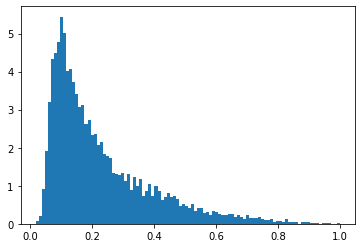

In [18]:
# Look at statistics of data
h2 = plt.hist(X_train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Intensity-based Segmentation
Here, we use a Laplace filter to do a basic intensity based segmentation

In [19]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2
from Classical_methods import laplace_segmentation

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

/home/mmu18/Desktop/Projects/AIWire/segmentation
/home/mmu18/Desktop/Projects/AIWire/segmentation


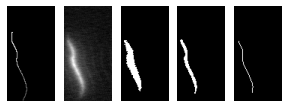

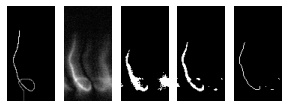

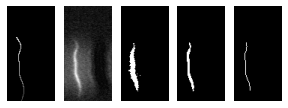

In [20]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

# Show first few segmentations
for i, (ground_truth, simulated, gt_pts) in enumerate(list(zip(y_test, X_test, pts_test))[:3]):
    centerline, cl_pts = get_centerline(laplace_segmentation(simulated),original_dir,'binary')
    show_images([ground_truth, simulated, simulated > 0.45, laplace_segmentation(simulated),centerline])

# Random Forest Segmentation
This is the first machine learning method we are using.


### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

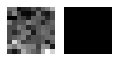

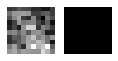

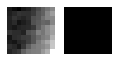

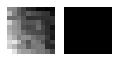

5
[5]


In [21]:
from random import randint

n_patches = 2000
patch_dim = 10
patches_sim, patches_gt = [], []
for i in range(n_patches):
    sample_train = X_train[i % len(X_train)]
    sample_test  = y_train[i % len(y_train)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    patches_sim.append(sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])
    patches_gt.append(sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim])

for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    show_images([patch_sim, patch_gt])
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
w = 0
c = patch_dim // 2
print(c)
print(list(range(c-w,c+w+1)))
patch_labels = np.array([p[c - w:c + w + 1, c - w:c + w + 1] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
# clf = RandomForestClassifier(max_depth=100)

X_patches_train, X_patches_test, y_patches_train, y_patches_test = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)
print(X_patches_train.shape, X_patches_test.shape, y_patches_train.shape, y_patches_test.shape)

#clf = RandomForestClassifier(max_depth=100, class_weight = [{0: 1, 1:50}] * y_patches_train.shape[-1])
clf = RandomForestClassifier(max_depth=100, class_weight = {0: 1, 1:50})
clf.fit(X_patches_train, y_patches_train.astype(bool).ravel())
preds = clf.predict(X_patches_test)

Class balance:  0.019461543890857323
(1700, 100) (300, 100) (1700, 1) (300, 1)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

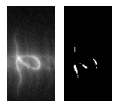

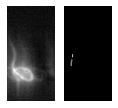

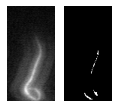

In [23]:
def rf_segmentation(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w + 1):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w + 1):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict(patch.reshape(1,-1))
            total_pred[i-w:i+w+1,j-w:j+w+1] = pred.reshape(2 * w + 1, 2 * w + 1)
    return total_pred

for i in range(3):
    pred = rf_segmentation(X[i])
    show_images([X[i], pred])